# Text Mining Project - Stock Sentiment - Test Notebook

## *Predicting market behavior from tweets*

### Group 42

Carolina Pinto - 20240494 <br>
Fábio dos Santos - 20240678 <br>
Guilherme – 2024 <br>
Mariana Sousa – 20240516 <br>

## Table of Contents
- [1. Import Libraries](#1-import-libraries)
- [2. Data Integration](#2-data-integration)
   - [2.1 Data Description](#21-data-description)
- [3. Data Content](#3-data-content)
- [4. Data Exploration](#4-data-exploration)
   - [4.1. Class Distribution](#41-class-distribution)
   - [4.2. Text Length](#42-text-length)
   - [4.3. Data Manipulation for Further Exploration](#43-data-manipulation-for-further-exploration)
   - [4.4. Most Frequent Words per Label](#44-most-frequent-words-per-label)
   - [4.5. Word Cloud by Label](#45-word-cloud-by-label)
- [5. Corpus Split](#5-corpus-split)
- [6. Data Preprocessing](#6-data-preprocessing)
- [7. Feature Engineering](#7-feature-engineering)
- [8. Classification Models](#8-classification-models)
- [9. Evaluation](#9-evaluation)

# 1. Import libraries

`Step 1` Import the required libraries.

In [ ]:
!pip install gensim

In [ ]:
!pip install keras_preprocessing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import gensim.downloader
import gensim.downloader as api
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences
import torch

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Data Integration

`Step 2` Import the dataset __train.csv__ using the method **read_csv()** from pandas.

In [ ]:
df = pd.read_csv('train.csv')

## 2.1. Data Description

`text`: tweets content. <br>
`label`: sentimental label, it can be bearish (0), bullish (1) or neutral (2).

# 3. Data Content

`Step 3` Check the first 5 rows of the dataset.

In [ ]:
df.head(20)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


`Step 4` Check the number of rows and columns of the data frame.

In [ ]:
df.shape

(9543, 2)

`Step 5` Check the features data types and info.

In [ ]:
df.dtypes

,0
text,object
label,int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


#### Conclusions
- Our data is composed of **9543** observations and **2** columns. <br>
- Variable text is object and variable label is an integer as expected. <br>
- There are no null values in the observations. <br>
- Our tweets have a lot of "noise" letters and symbols like hashtags, dollar signs, links, punctuation and numbers. This should be adressed later on.

# 4. Data Exploration

`Step 6` Defining the colors to use in our visualizations for consistent representation (NOVA IMS official colors).

In [ ]:
# color_390 = (190/255, 214/255, 47/255)  # Pantone 390 C
# color_431 = (92/255, 102/255, 108/255)  # Pantone 431 C

## 4.1. Class Distribution

`Step 7` Check Class Distribution (plot and percentage).

In [ ]:
# sns.countplot(data=df, x='label', color=color_390, edgecolor=color_431)
# plt.title("Sentiment Label Distribution")
# plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
# plt.show()

# print(df['label'].value_counts(normalize=True) * 100)

- We can see that our labels are unbalanced, more than 60% is classified as "Neutral", 20% as "Bullish" and 15% as "Bearish".

## 4.2. Text Length

`Step 8` Check Text Length of the tweets per label.

In [ ]:
# df['text_length'] = df['text'].apply(len)

# sns.histplot(df['text_length'], bins=30, kde=True, color=color_390, edgecolor=color_431)
# plt.title("Distribution of Tweet Lengths")
# plt.xlabel("Length of Tweet")
# plt.show()

# # Grouped by label
# sns.boxplot(data=df, x='label', y='text_length', color=color_390)
# plt.xticks([0, 1, 2], ['Bearish', 'Bullish', 'Neutral'])
# plt.title("Tweet Length by Sentiment")
# plt.show()

- The different labels have a simillar distribution in terms of tweet length. <br>
- The tweets length are distributed in a normal distribution with two peaks at length between 60-65 and 140-145. <br>
- There are a lot of tweets (approximately 1000) with length between 60-65, and around 900 with length between 140-145. This represents approximately 19% of the data.

## 4.3. Data Manipulation for Further Exploration

- We want to check the most frequent words per label and the word clouds for each label. At this point our data is raw and we wouldn't get significant analysis. <br>
- For that reason in this section we will copy our dataset in order to do a small preprocessing (tokenize) and then perform the desired analysis. <br>
- After this data manipulation and the referred two analysis we will continue our work with corpus split and data preprocessing from the original dataset.

`Step 9` Using a copy of our dataset we tokenize the tweets in order to have a more accurate analysis.

In [ ]:
# df_copy = deepcopy(df)

# stop_words = set(stopwords.words('english'))

# # Preprocessing: basic cleaning and tokenization
# def clean_and_tokenize(text):
#     text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text)
#     text = text.lower()
#     tokens = text.split()
#     tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
#     return tokens

# df_copy['tokens'] = df_copy['text'].apply(clean_and_tokenize)

# df_copy

## 4.4. Most Frequent Words per Label

`Step 10` Check top 10 most frequent words per label.

In [ ]:
# # Map labels to names
# label_names = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# # Show top 10 words per label
# def get_top_words(df, label, top_n=10):
#     all_words = [word for tokens in df[df['label'] == label]['tokens'] for word in tokens]
#     most_common = Counter(all_words).most_common(top_n)

#     print(f"\nTop {top_n} words for {label_names[label]} tweets:")
#     for word, count in most_common:
#         print(f"{word}: {count}")

#     # Plot
#     words, counts = zip(*most_common)
#     plt.figure(figsize=(10, 5))
#     sns.barplot(x=list(counts), y=list(words), color=color_390)
#     plt.title(f"Top {top_n} Words - {label_names[label]}")
#     plt.xlabel("Frequency")
#     plt.ylabel("Words")
#     plt.tight_layout()
#     plt.show()

# # Loop through each label
# for label in sorted(df_copy['label'].unique()):
#     get_top_words(df_copy, label, top_n=10)

In [ ]:
# df_copy.text_length.describe()

- All three labels have the same most common word as "stock" but also a good amount of the plural "stocks". <br>
- "us" also have a good representation in all the 3 labels. <br>
- Even though there is a significance difference between labels there are still some common words between them. <br>
- Neutral tweets don't have such a big gap between the top 5 most common words, which makes the words distribution more balanced. <br>
- The largest tweet have 190 words while the smallest one have 2. <br>
- In average the tweets have around 79 words.

## 4.5. Word Cloud by Label

`Step 11` Check Word Cloud of the different labels.

In [ ]:
# def plot_wordcloud(df, label, label_names):
#     # Combine all tokens into one string
#     text = " ".join(df[df['label'] == label]['tokens'].sum())

#     # Generate word cloud
#     wordcloud = WordCloud(width=800, height=400, background_color='white',
#                           colormap='viridis').generate(text)

#     print(f"Word cloud for {label_names[label]} label:")

#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Generate word clouds for each label
# for label in sorted(df_copy['label'].unique()):
#     plot_wordcloud(df_copy, label, label_names)

- As previously observed, “stock” appears as the most prominent word across all sentiment labels. However, in the Neutral label, it stands out less clearly due to a more even distribution among the top words. <br>
- Overall, the Neutral label exhibits a more balanced word frequency distribution compared to the Bearish and Bullish labels. This aligns with expectations: neutral tweets typically lack strong sentiment indicators, resulting in fewer dominant or sentiment-specific keywords that clearly classify the text as bullish or bearish.

# 5. Corpus Split

- Since our corpus have less than 10000 rows we would split it in train, validation and test in a 80%/10%/10% split. In our project we have a separate test csv file therefore we'll use it as our test. We will split this data in train and validation in a 80%/20% split.

`Step 12` Create a copy of the original dataframe named **data**.

In [ ]:
data = deepcopy(df)
data

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


__`Step 13`__ Create a varaible called `X` that store the values of the input features and `y` that stores the values of the target feature.

In [ ]:
X = data.drop(columns=['label'], axis =1)
y = data['label']

__`Step 14`__ Split the data in train and validation set in a 80/20 split, with random_state = 42, stratification by y and with shuffle of the dataset.

In [ ]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    shuffle=True
                                                    )

- This first split was made for testing the preprocessing methods. For feature selection and model assessment and optimization we will use cross validation with the preprocessing inside.

# 6. Data Preprocessing

<span style="color:red">
PARA OPTIMIZAR O MODELO: </span> <br>
- Procurar diferentes lemmatizers e stemmers e testa-los em gridsearch para ver qual o melhor modelo <br>
- Procurar outras formas de preprocessing (corrigir typos, etc etc)<br>
- Temos de aplicar o preprocessement ao test?


__`Step 15`__ Create a function to do the data preprocessing. It includes:<br>
|Preprocessement                                  |
|------------------------------------|
| Lowercasing |
| Removes Regular Unwanted Expressions   |
| Remove Punctuation           |
| Tokenization |
| Remove Stop Words                    |
| Lemmatization |
| Stemming                    |

In [ ]:
lemma = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def preprocess(text_list, lemma = None, stemmer = None, word2vec=False):
    """
    Return the prepocessed text in a list "updates".

    Parameters:
    text_list : list to be preprocessed
    use_lemmatize : bool, optional
        If True, applies lemmatization to the tokens. Default is True.
    use_stemmer : bool, optional
        If True, applies stemming to the tokens. Default is False.
    """

    stop_words = set(stopwords.words('english'))

    updates = []

    for j in tqdm(text_list):

        text = j

        # Lower case text
        text = text.lower()

        # Remove Regular Unwanted Expressions
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)

        # Remove Punctuation
        text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)

        # Tokenize the text
        tokens = word_tokenize(text)

        #Remove Stopwords
        tokens = [word for word in tokens if word not in stop_words]

        #Lemmatize
        if lemma:
            tokens = [lemma.lemmatize(word) for word in tokens]

        #Stemming
        if stemmer:
            tokens = [stemmer.stem(word) for word in tokens]

        # Rejoin tokens

        if word2vec:
            cleaned_text=tokens
        else:
            cleaned_text = " ".join(tokens)

        updates.append(cleaned_text)

    return updates

__`Step 16`__ Apply the preprocessement to X_train and X_val.

In [ ]:
X_train['tokens'] = preprocess(X_train['text'])
X_train

100%|██████████| 7634/7634 [00:01<00:00, 3858.71it/s]


,text,tokens
2186,Nasdaq prices 600M of 0.875% senior notes,nasdaq prices senior notes
6819,Futures up https://t.co/diz7v5lmVb,futures
6157,$ECONX: November Nonfarm Private Payrolls 125K...,econx november nonfarm private payrolls k vs k...
2462,Twitter users explain why Kohl's stock just go...,twitter users explain kohls stock got oblitera...
4097,Agilysys : Restaurants Find Sustainable Method...,agilysys restaurants find sustainable methods ...
...,...,...
2807,Japan Tobacco reports FY results,japan tobacco reports fy results
704,The Fed's Emergence as a Power Player Poses Ne...,feds emergence power player poses new risks in...
990,How the Rise of At-Home Fitness Services Could...,rise athome fitness services could benefit lul...
4362,Daniel Loeb's Top 5 Buys in the 3rd Quarter,daniel loebs top buys rd quarter


In [ ]:
X_val['tokens'] = preprocess(X_val['text'])
X_val

100%|██████████| 1909/1909 [00:00<00:00, 4606.31it/s]


,text,tokens
4693,i love it when fertility clinic's decorate ......,love fertility clinics decorate even thanks gi...
1599,IRS investigators scrutinize Bitcoin ATMs and ...,irs investigators scrutinize bitcoin atms kiosks
9238,$SRPT higher by 4.5% today clearing 21 MA and ...,srpt higher today clearing nearing feb opex va...
122,Wells Fargo Downgrades Netflix On Spending Con...,wells fargo downgrades netflix spending concerns
2475,DocuSign signs off on another solid earnings r...,docusign signs another solid earnings result docu
...,...,...
7131,'A lot of people feel defeated...Trump always ...,lot people feel defeatedtrump always wins seem...
34,Anchiano Therapeutics downgraded to peer perfo...,anchiano therapeutics downgraded peer perform ...
7109,Wall Street rallies on Friday but multi-week w...,wall street rallies friday multiweek win strea...
5855,CORRECTED-Ex-British Airways executive indicte...,correctedexbritish airways executive indicted ...


In [ ]:
X_train_cleaned=preprocess(X_train['text'])
X_val_cleaned=preprocess(X_val['text'])

100%|██████████| 1909/1909 [00:00<00:00, 3526.66it/s]


# 7. Feature Engineering

This section contains different feature engineering approachs that our group tested (bag of words, word2vec and transformers).

In [ ]:
dim=100

## 7.1. Bag of Words (BoW)

__`Step 17`__ Apply BoW to the X_train already preprocessed.

In [ ]:
bow = CountVectorizer(binary=True)
X_train_bow = bow.fit_transform(X_train_cleaned)
X_val_bow = bow.transform(X_val_cleaned)

__`Step 18`__ Visualize the 20 most common words in the BoW created.

In [ ]:
# # Visualize top Bag of Words terms (Cleaned)
# clean_bow_sum = np.array(X_train_bow.sum(axis=0)).flatten()
# clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
# clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

# sns.barplot(data=clean_top, x='count', y='term', color=color_390, edgecolor=color_431)
# plt.title("Top Bag-of-Words Terms (Cleaned)")
# plt.show()

## 7.2. Word2vec - WIP

__`Step 19`__ Apply word2vec to the X_train already preprocessed.

In [ ]:
# X_train_cleaned_word2vec=preprocess(X_train['text'], word2vec=True)

In [ ]:
# # Tokenize the tokens column for Word2Vec input
# X_train_tokens = [text.split() for text in X_train['tokens']]
# X_val_tokens = [text.split() for text in X_val['tokens']]

# model = Word2Vec(
#     sentences=corpus,
#     vector_size=5,    # size of the embedding vectors
#     window=2,         # context window size -  maximum distance between a target word and its context words
#     min_count=1,      # minimum word frequency that a word mus have in the corpus to be included in the modelx
#     sg=1              # 1 for skip-gram; 0 for CBOW (Predict the target word based on its context words.)
# )

# Train Word2Vec model on training data
w2v_model = Word2Vec(sentences=X_train_cleaned_word2vec, vector_size=100, window=5, min_count=1, workers=4, sg=1)

__`Step 20`__ Embeddings for each tweet in the corpus - average of the embeddings of each word in that tweet - suitable for models like KNN and Logistic Regression

In [ ]:
def average_embedding(text, model, dim):
    words = text.split()
    vectors = []
    for word in words:
        if word in model:
            vectors.append(model[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

In [ ]:
# These are embeddings with average (take the average of all the words in the tweet) - suitable for KNN and Logistic Regression
X_train_avgembeddings_from_scratch = np.array([average_embedding(text, w2v_model.wv, dim=dim) for text in X_train_cleaned])
X_val_avgembeddings_from_scratch = np.array([average_embedding(text, w2v_model.wv, dim=dim) for text in X_val_cleaned])

__`Step 21`__ Get the embeddings for each word - do not need to make the average - suitable for RNN and LSTM. These models accepts as inputs vectors of vectors

⚠️ Commented out because this is not suitable for KNN and Logistic

In [ ]:
# def corpus2vec(corpus, w2v):
#     index_set = set(w2v.index_to_key)  # List of all words/vocabulary in the model
#     word_vec = w2v.get_vector           # Creates a short cut that retrieves the embedding method for a given word
#     return [
#         [word_vec(word) for word in doc.split() if word in index_set]
#         for doc in tqdm(corpus)
#     ]

In [ ]:
# # these are embeddings where each word is a vector (not computed the average across words) - suitable for RNN and LSTM
# X_train_embeddings_from_scratch = corpus2vec(X_train_cleaned, w2v_model.wv)
# X_val_embeddings_from_scratch = corpus2vec(X_val_cleaned, w2v_model.wv)

## 7.3. Word Vectors with Glove (Pretrained Word Vectors)

⚠️ Commented out because this is not suitable for KNN and Logistic

__`Step 21`__ Download the pretrained word vectors.

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# we will use the one regarding twitter
glove_model_100 = gensim.downloader.load(f'glove-twitter-{dim}')

In [ ]:
X_train_avgembeddings_glove = np.array([average_embedding(text, glove_model_100, dim=dim) for text in X_train_cleaned])
X_val_avgembeddings_glove = np.array([average_embedding(text, glove_model_100, dim=dim) for text in X_val_cleaned])

In [ ]:
# X_train_embeddings_glove = corpus2vec(X_train_cleaned, glove_model_100)
# X_val_embeddings_glove = corpus2vec(X_val_cleaned, glove_model_100)

## 7.3. Transformer (Encoder)

In [ ]:
MODEL = "assemblyai/distilbert-base-uncased-sst2"
#MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
#MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

In [ ]:
model = pipeline("feature-extraction", model=MODEL, tokenizer=MODEL, batch_size=16, truncation=True)

Device set to use cpu


In [ ]:
def generate_embeddings(
    texts,
    embeddings_model,
    for_sequence_model=False,
    desc="Generating Embeddings"
):
    """
    Generates either CLS embeddings (1 per text) or full token embeddings (sequence) for each input text.

    Args:
        texts (list of str): List of input texts.
        embeddings_model (callable): Hugging Face pipeline("feature-extraction", ...).
        use_cls (bool): If True, use the CLS token embedding; if False, use mean pooling.
        for_sequence_model (bool): If True, return full token-level embeddings (for RNNs).
        desc (str): tqdm progress bar description.

    Returns:
        If for_sequence_model:
            List[torch.Tensor]: Each tensor is [seq_len, hidden_dim].
        Else:
            torch.Tensor: Tensor of shape [num_texts, hidden_dim].
    """
    processed = []

    for text in tqdm(texts, desc=desc):
        output = embeddings_model(text)  # list[list[list]]
        token_embeddings = output[0]  # get token vectors from the first (and only) item in batch
        token_embeddings = torch.tensor(token_embeddings)  # shape: [seq_len, hidden_dim]

        if for_sequence_model:
            processed.append(token_embeddings)  # shape: [seq_len, hidden_dim]
        else:
            summary_vector = token_embeddings[0]  # [CLS] token embedding
            processed.append(summary_vector)

    if for_sequence_model:
        return processed
    else:
        return torch.stack(processed)  # shape: [num_texts, hidden_dim]


In [ ]:
X_train_avgembeddings_transformer=generate_embeddings(X_train_cleaned, model)
X_val_avgembeddings_transformer=generate_embeddings(X_val_cleaned, model)

Generating Embeddings: 100%|██████████| 1909/1909 [01:49<00:00, 17.46it/s]


In [ ]:
# X_train_embeddings_transformer=generate_embeddings(X_train_cleaned, model, for_sequence_model=True)
# X_val_embeddings_transformer=generate_embeddings(X_val_cleaned, model, for_sequence_model=True)

In [ ]:
raise RuntimeError("STOP HERE: This is the end of preprocessing.")

RuntimeError: STOP HERE: This is the end of preprocessing.

# 8. Classification Models & Evaluation

X_train_avgembeddings_(...) - for KNN and logistic regression models. Each tweet is a vector with the average embeddings of each word
X_train_embeddings_(...) - for RNN and LTSM. Each tweet is a vector of vector. Each word is an embedding, all embaddings have the same size. It is needed padding, done below in the RNN and LSTM section.

## 8.1 Defining configurations and functions

In [ ]:
feature_sets = {
    "BoW": (X_train_bow, X_val_bow),
    "Word2Vec": (X_train_avgembeddings_from_scratch, X_val_avgembeddings_from_scratch),
    "GloVe": (X_train_avgembeddings_glove, X_val_avgembeddings_glove),
    "Transformer": (X_train_avgembeddings_transformer, X_val_avgembeddings_transformer)
}


In [ ]:
knn_configs = [
    {"n_neighbors": 5, "metric": "cosine", "weights": "uniform"},
    {"n_neighbors": 10, "metric": "cosine", "weights": "distance"},
    {"n_neighbors": 15, "metric": "euclidean", "weights": "distance"}
]

In [ ]:
logreg_configs = [
    {"max_iter": 1000, "solver": "lbfgs"},
    {"max_iter": 1000, "solver": "saga"},
    {"max_iter": 1000, "solver": "liblinear"}
]

In [ ]:
def evaluate_and_print(model, X_train, y_train, X_val, y_val, model_name, rep_name, config):
    print("--------------------------------------------------------------------------------------")
    print(f"\n Model: {model_name}, Embedding: {rep_name}, Config: {config}")
    print("--------------------------------------------------------------------------------------")

    results = {}

    # --- TRAINING METRICS ---
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    print("\n📘 TRAINING METRICS")
    print(f"Accuracy: {train_acc:.4f}")
    for label in ['bearish', 'bullish', 'neutral']:
        metrics = train_report[label]
        print(f"\nClass: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-score:  {metrics['f1-score']:.4f}")
    print(f"\nMacro Avg F1-score: {train_report['macro avg']['f1-score']:.4f}")

    # --- VALIDATION METRICS ---
    y_val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

    print("\n📗 VALIDATION METRICS")
    print(f"Accuracy: {val_acc:.4f}")
    for label in ['bearish', 'bullish', 'neutral']:
        metrics = val_report[label]
        print(f"\nClass: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-score:  {metrics['f1-score']:.4f}")
    print(f"\nMacro Avg F1-score: {val_report['macro avg']['f1-score']:.4f}")

    # --- CONFUSION MATRIX (Validation) ---
    cm = confusion_matrix(y_val, y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bearish', 'bullish', 'neutral'])
    fig, ax = plt.subplots(figsize=(5.5, 4.5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"Confusion Matrix - {model_name} + {rep_name}")
    plt.tight_layout()
    plt.show()

    # --- Return all scores for storage ---
    results = {
        "model": model_name,
        "embedding": rep_name,
        "config": config,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_f1": train_report["macro avg"]["f1-score"],
        "val_f1": val_report["macro avg"]["f1-score"],
        "f1_gap": train_report["macro avg"]["f1-score"] - val_report["macro avg"]["f1-score"]
    }

    return results



## 8.2. KNN Classifier

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 5, 'metric': 'cosine', 'weights': 'uniform'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.8267

Class: bearish
  Precision: 0.7053
  Recall:    0.5953
  F1-score:  0.6457

Class: bullish
  Precision: 0.7153
  Recall:    0.7334
  F1-score:  0.7242

Class: neutral
  Precision: 0.8845
  Recall:    0.9098
  F1-score:  0.8970

Macro Avg F1-score: 0.7556

📗 VALIDATION METRICS
Accuracy: 0.7360

Class: bearish
  Precision: 0.5323
  Recall:    0.4583
  F1-score:  0.4925

Class: bullish
  Precision: 0.5550
  Recall:    0.6156
  F1-score:  0.5837

Class: neutral
  Precision: 0.8395
  Recall:    0.8382
  F1-score:  0.8389

Macro Avg F1-score: 0.6384


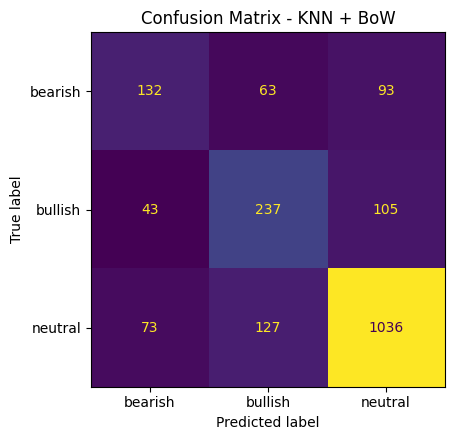

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9984

Class: bearish
  Precision: 0.9974
  Recall:    0.9965
  F1-score:  0.9970

Class: bullish
  Precision: 0.9955
  Recall:    0.9974
  F1-score:  0.9964

Class: neutral
  Precision: 0.9996
  Recall:    0.9992
  F1-score:  0.9994

Macro Avg F1-score: 0.9976

📗 VALIDATION METRICS
Accuracy: 0.7768

Class: bearish
  Precision: 0.7103
  Recall:    0.3576
  F1-score:  0.4758

Class: bullish
  Precision: 0.6556
  Recall:    0.6182
  F1-score:  0.6364

Class: neutral
  Precision: 0.8151
  Recall:    0.9239
  F1-score:  0.8661

Macro Avg F1-score: 0.6594


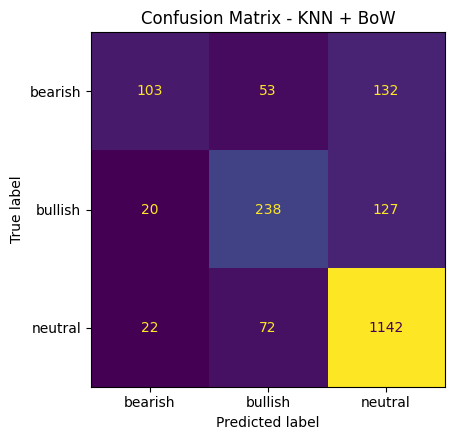

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: BoW, Config: {'n_neighbors': 15, 'metric': 'euclidean', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9984

Class: bearish
  Precision: 0.9957
  Recall:    0.9983
  F1-score:  0.9970

Class: bullish
  Precision: 0.9955
  Recall:    0.9974
  F1-score:  0.9964

Class: neutral
  Precision: 1.0000
  Recall:    0.9988
  F1-score:  0.9994

Macro Avg F1-score: 0.9976

📗 VALIDATION METRICS
Accuracy: 0.6852

Class: bearish
  Precision: 0.7600
  Recall:    0.0660
  F1-score:  0.1214

Class: bullish
  Precision: 0.8788
  Recall:    0.1506
  F1-score:  0.2572

Class: neutral
  Precision: 0.6771
  Recall:    0.9960
  F1-score:  0.8062

Macro Avg F1-score: 0.3949


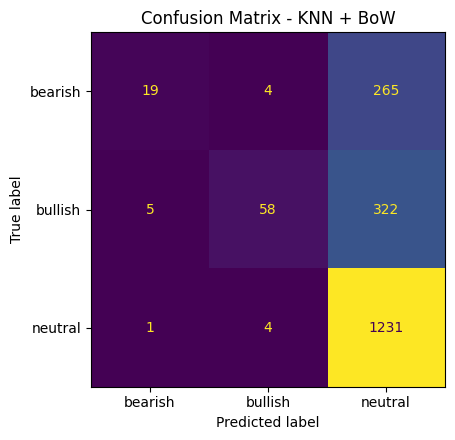

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: Word2Vec, Config: {'n_neighbors': 5, 'metric': 'cosine', 'weights': 'uniform'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7655

Class: bearish
  Precision: 0.5444
  Recall:    0.5043
  F1-score:  0.5236

Class: bullish
  Precision: 0.6358
  Recall:    0.5618
  F1-score:  0.5965

Class: neutral
  Precision: 0.8448
  Recall:    0.8899
  F1-score:  0.8668

Macro Avg F1-score: 0.6623

📗 VALIDATION METRICS
Accuracy: 0.6370

Class: bearish
  Precision: 0.2989
  Recall:    0.2812
  F1-score:  0.2898

Class: bullish
  Precision: 0.4298
  Recall:    0.3896
  F1-score:  0.4087

Class: neutral
  Precision: 0.7642
  Recall:    0.7969
  F1-score:  0.7802

Macro Avg F1-score: 0.4929


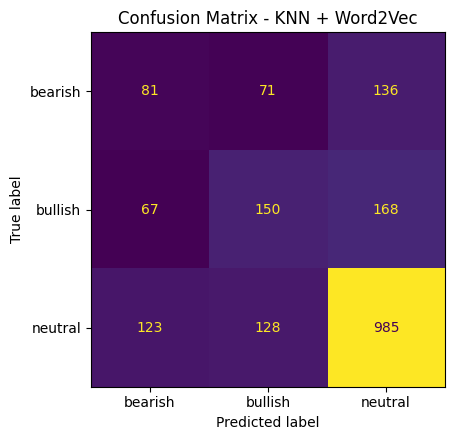

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: Word2Vec, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9988

Class: bearish
  Precision: 0.9965
  Recall:    0.9983
  F1-score:  0.9974

Class: bullish
  Precision: 0.9968
  Recall:    0.9974
  F1-score:  0.9971

Class: neutral
  Precision: 1.0000
  Recall:    0.9994
  F1-score:  0.9997

Macro Avg F1-score: 0.9981

📗 VALIDATION METRICS
Accuracy: 0.6805

Class: bearish
  Precision: 0.3519
  Recall:    0.1979
  F1-score:  0.2533

Class: bullish
  Precision: 0.4910
  Recall:    0.3558
  F1-score:  0.4127

Class: neutral
  Precision: 0.7527
  Recall:    0.8940
  F1-score:  0.8173

Macro Avg F1-score: 0.4944


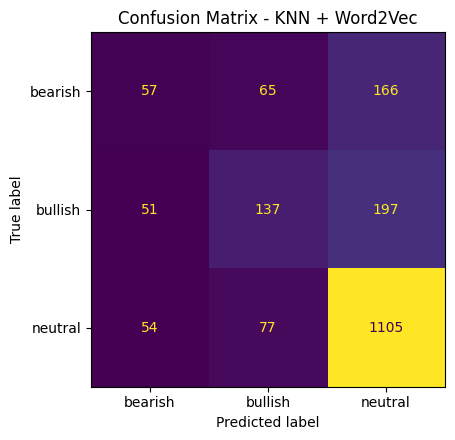

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: Word2Vec, Config: {'n_neighbors': 15, 'metric': 'euclidean', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9988

Class: bearish
  Precision: 0.9974
  Recall:    0.9974
  F1-score:  0.9974

Class: bullish
  Precision: 0.9968
  Recall:    0.9974
  F1-score:  0.9971

Class: neutral
  Precision: 0.9998
  Recall:    0.9996
  F1-score:  0.9997

Macro Avg F1-score: 0.9981

📗 VALIDATION METRICS
Accuracy: 0.6752

Class: bearish
  Precision: 0.3763
  Recall:    0.1215
  F1-score:  0.1837

Class: bullish
  Precision: 0.4695
  Recall:    0.3195
  F1-score:  0.3802

Class: neutral
  Precision: 0.7278
  Recall:    0.9150
  F1-score:  0.8108

Macro Avg F1-score: 0.4582


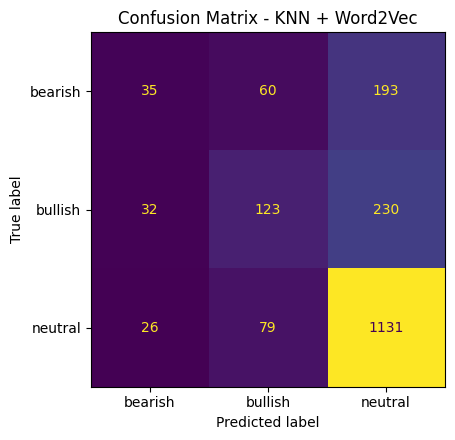

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: GloVe, Config: {'n_neighbors': 5, 'metric': 'cosine', 'weights': 'uniform'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.8064

Class: bearish
  Precision: 0.6513
  Recall:    0.5763
  F1-score:  0.6115

Class: bullish
  Precision: 0.6803
  Recall:    0.6944
  F1-score:  0.6873

Class: neutral
  Precision: 0.8771
  Recall:    0.8950
  F1-score:  0.8859

Macro Avg F1-score: 0.7282

📗 VALIDATION METRICS
Accuracy: 0.7103

Class: bearish
  Precision: 0.4240
  Recall:    0.3681
  F1-score:  0.3941

Class: bullish
  Precision: 0.5227
  Recall:    0.5377
  F1-score:  0.5301

Class: neutral
  Precision: 0.8258
  Recall:    0.8439
  F1-score:  0.8347

Macro Avg F1-score: 0.5863


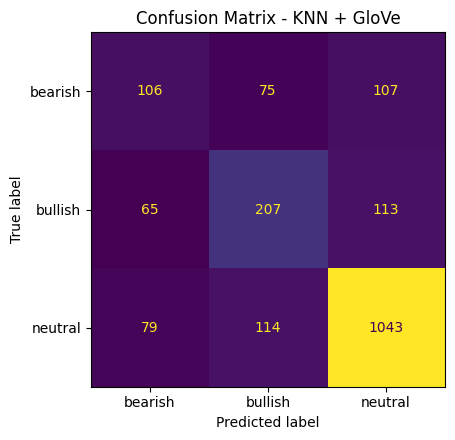

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: GloVe, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9992

Class: bearish
  Precision: 0.9974
  Recall:    1.0000
  F1-score:  0.9987

Class: bullish
  Precision: 0.9981
  Recall:    0.9987
  F1-score:  0.9984

Class: neutral
  Precision: 1.0000
  Recall:    0.9992
  F1-score:  0.9996

Macro Avg F1-score: 0.9989

📗 VALIDATION METRICS
Accuracy: 0.7533

Class: bearish
  Precision: 0.5862
  Recall:    0.3542
  F1-score:  0.4416

Class: bullish
  Precision: 0.6212
  Recall:    0.5325
  F1-score:  0.5734

Class: neutral
  Precision: 0.8050
  Recall:    0.9150
  F1-score:  0.8565

Macro Avg F1-score: 0.6238


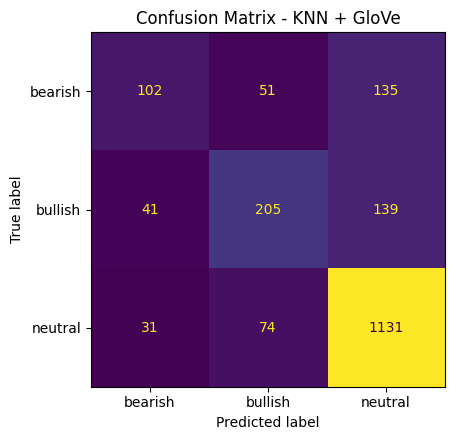

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: GloVe, Config: {'n_neighbors': 15, 'metric': 'euclidean', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9986

Class: bearish
  Precision: 0.9974
  Recall:    0.9965
  F1-score:  0.9970

Class: bullish
  Precision: 0.9974
  Recall:    0.9961
  F1-score:  0.9967

Class: neutral
  Precision: 0.9992
  Recall:    0.9998
  F1-score:  0.9995

Macro Avg F1-score: 0.9977

📗 VALIDATION METRICS
Accuracy: 0.7465

Class: bearish
  Precision: 0.6154
  Recall:    0.3056
  F1-score:  0.4084

Class: bullish
  Precision: 0.6144
  Recall:    0.5091
  F1-score:  0.5568

Class: neutral
  Precision: 0.7885
  Recall:    0.9231
  F1-score:  0.8505

Macro Avg F1-score: 0.6052


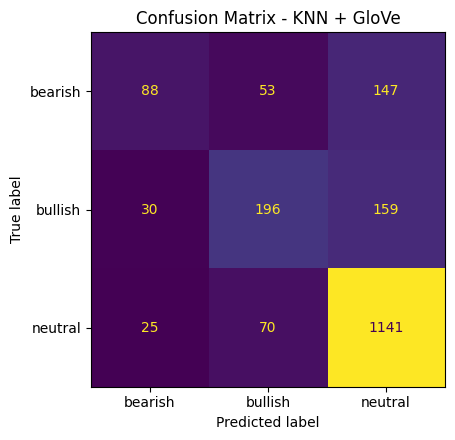

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: Transformer, Config: {'n_neighbors': 5, 'metric': 'cosine', 'weights': 'uniform'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.8026

Class: bearish
  Precision: 0.6208
  Recall:    0.7080
  F1-score:  0.6615

Class: bullish
  Precision: 0.6986
  Recall:    0.6632
  F1-score:  0.6805

Class: neutral
  Precision: 0.8831
  Recall:    0.8681
  F1-score:  0.8755

Macro Avg F1-score: 0.7392

📗 VALIDATION METRICS
Accuracy: 0.7203

Class: bearish
  Precision: 0.4806
  Recall:    0.5590
  F1-score:  0.5169

Class: bullish
  Precision: 0.6096
  Recall:    0.5273
  F1-score:  0.5655

Class: neutral
  Precision: 0.8147
  Recall:    0.8180
  F1-score:  0.8163

Macro Avg F1-score: 0.6329


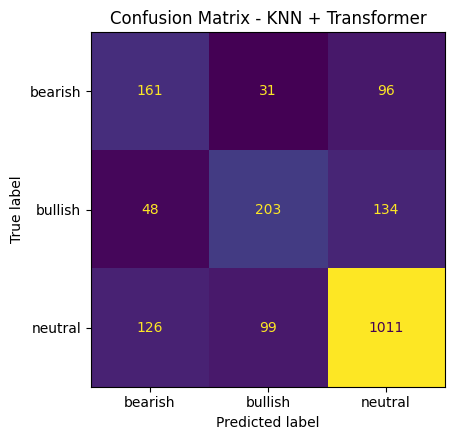

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: Transformer, Config: {'n_neighbors': 10, 'metric': 'cosine', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9988

Class: bearish
  Precision: 0.9974
  Recall:    0.9974
  F1-score:  0.9974

Class: bullish
  Precision: 0.9961
  Recall:    0.9980
  F1-score:  0.9971

Class: neutral
  Precision: 1.0000
  Recall:    0.9994
  F1-score:  0.9997

Macro Avg F1-score: 0.9981

📗 VALIDATION METRICS
Accuracy: 0.7423

Class: bearish
  Precision: 0.5357
  Recall:    0.5208
  F1-score:  0.5282

Class: bullish
  Precision: 0.6771
  Recall:    0.5065
  F1-score:  0.5795

Class: neutral
  Precision: 0.7994
  Recall:    0.8673
  F1-score:  0.8320

Macro Avg F1-score: 0.6465


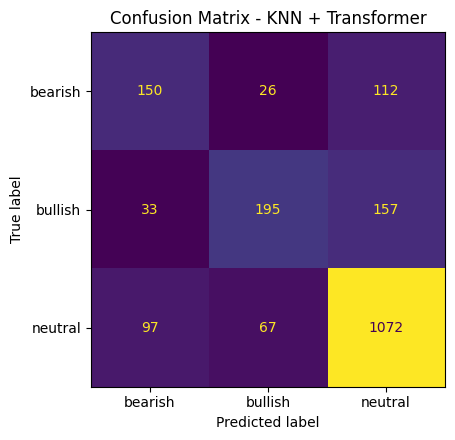

--------------------------------------------------------------------------------------

 Model: KNN, Embedding: Transformer, Config: {'n_neighbors': 15, 'metric': 'euclidean', 'weights': 'distance'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9988

Class: bearish
  Precision: 0.9983
  Recall:    0.9965
  F1-score:  0.9974

Class: bullish
  Precision: 0.9961
  Recall:    0.9980
  F1-score:  0.9971

Class: neutral
  Precision: 0.9998
  Recall:    0.9996
  F1-score:  0.9997

Macro Avg F1-score: 0.9981

📗 VALIDATION METRICS
Accuracy: 0.7402

Class: bearish
  Precision: 0.5363
  Recall:    0.4618
  F1-score:  0.4963

Class: bullish
  Precision: 0.6844
  Recall:    0.4675
  F1-score:  0.5556

Class: neutral
  Precision: 0.7868
  Recall:    0.8900
  F1-score:  0.8352

Macro Avg F1-score: 0.6290


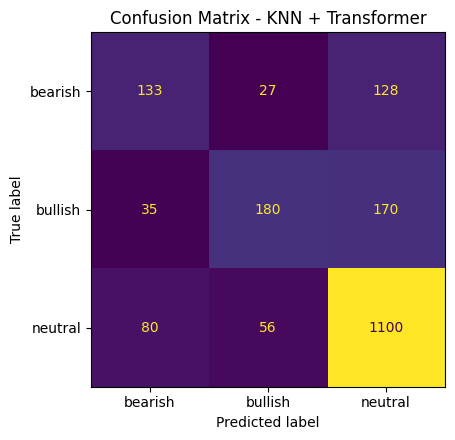

In [ ]:
results = []

for rep_name, (X_train, X_val) in feature_sets.items():
    for config in knn_configs:
        # Initialize model with current hyperparameters
        knn = KNeighborsClassifier(**config)
        # Train and predict
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        # Evaluate
        acc = evaluate_and_print(knn, X_train, y_train, X_val, y_val, "KNN", rep_name, config)
        results.append({
            "embedding": rep_name,
            "config": config,
            "accuracy": acc
        })


## 8.3 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9766

Class: bearish
  Precision: 0.9827
  Recall:    0.9341
  F1-score:  0.9578

Class: bullish
  Precision: 0.9748
  Recall:    0.9538
  F1-score:  0.9642

Class: neutral
  Precision: 0.9758
  Recall:    0.9935
  F1-score:  0.9846

Macro Avg F1-score: 0.9688

📗 VALIDATION METRICS
Accuracy: 0.7826

Class: bearish
  Precision: 0.6533
  Recall:    0.4514
  F1-score:  0.5339

Class: bullish
  Precision: 0.7356
  Recall:    0.5636
  F1-score:  0.6382

Class: neutral
  Precision: 0.8106
  Recall:    0.9280
  F1-score:  0.8653

Macro Avg F1-score: 0.6792


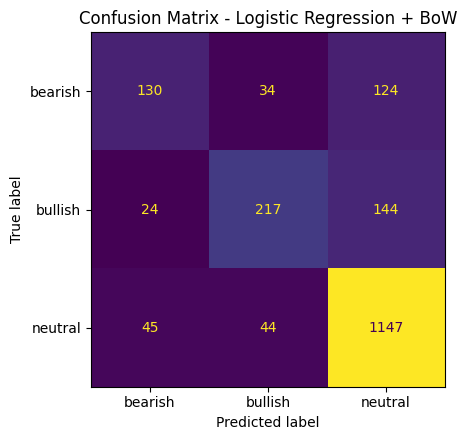

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9771

Class: bearish
  Precision: 0.9827
  Recall:    0.9359
  F1-score:  0.9587

Class: bullish
  Precision: 0.9754
  Recall:    0.9551
  F1-score:  0.9652

Class: neutral
  Precision: 0.9763
  Recall:    0.9935
  F1-score:  0.9849

Macro Avg F1-score: 0.9696

📗 VALIDATION METRICS
Accuracy: 0.7831

Class: bearish
  Precision: 0.6567
  Recall:    0.4583
  F1-score:  0.5399

Class: bullish
  Precision: 0.7273
  Recall:    0.5610
  F1-score:  0.6334

Class: neutral
  Precision: 0.8129
  Recall:    0.9280
  F1-score:  0.8666

Macro Avg F1-score: 0.6800


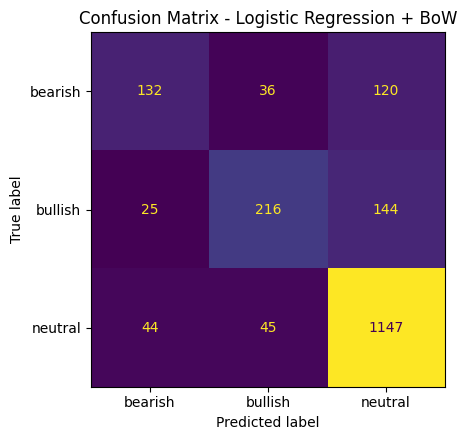

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: BoW, Config: {'max_iter': 1000, 'solver': 'liblinear'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.9498

Class: bearish
  Precision: 0.9706
  Recall:    0.8579
  F1-score:  0.9108

Class: bullish
  Precision: 0.9542
  Recall:    0.8947
  F1-score:  0.9235

Class: neutral
  Precision: 0.9445
  Recall:    0.9885
  F1-score:  0.9660

Macro Avg F1-score: 0.9334

📗 VALIDATION METRICS
Accuracy: 0.7847

Class: bearish
  Precision: 0.6959
  Recall:    0.4132
  F1-score:  0.5185

Class: bullish
  Precision: 0.7721
  Recall:    0.5455
  F1-score:  0.6393

Class: neutral
  Precision: 0.7974
  Recall:    0.9458
  F1-score:  0.8653

Macro Avg F1-score: 0.6744


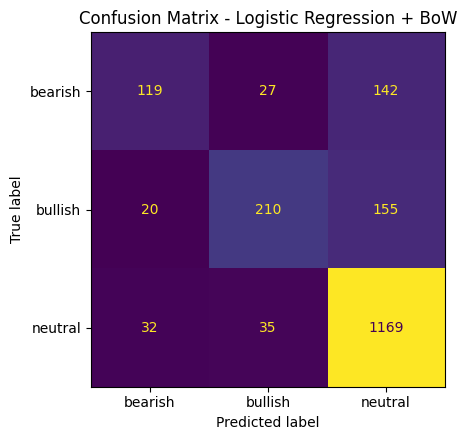

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Word2Vec, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.6677

Class: bearish
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: bullish
  Precision: 0.5157
  Recall:    0.2035
  F1-score:  0.2918

Class: neutral
  Precision: 0.6808
  Recall:    0.9680
  F1-score:  0.7994

Macro Avg F1-score: 0.3637

📗 VALIDATION METRICS
Accuracy: 0.6606

Class: bearish
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: bullish
  Precision: 0.4607
  Recall:    0.2130
  F1-score:  0.2913

Class: neutral
  Precision: 0.6811
  Recall:    0.9539
  F1-score:  0.7947

Macro Avg F1-score: 0.3620


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

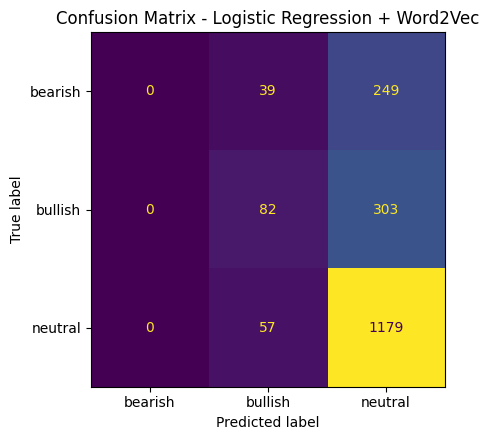

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Word2Vec, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.6674

Class: bearish
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: bullish
  Precision: 0.5157
  Recall:    0.2029
  F1-score:  0.2912

Class: neutral
  Precision: 0.6805
  Recall:    0.9678
  F1-score:  0.7991

Macro Avg F1-score: 0.3634

📗 VALIDATION METRICS
Accuracy: 0.6600

Class: bearish
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: bullish
  Precision: 0.4576
  Recall:    0.2104
  F1-score:  0.2883

Class: neutral
  Precision: 0.6807
  Recall:    0.9539
  F1-score:  0.7945

Macro Avg F1-score: 0.3609


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

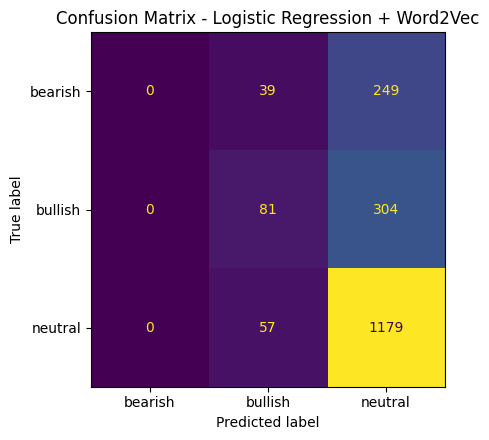

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Word2Vec, Config: {'max_iter': 1000, 'solver': 'liblinear'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.6660

Class: bearish
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: bullish
  Precision: 0.5180
  Recall:    0.1873
  F1-score:  0.2751

Class: neutral
  Precision: 0.6776
  Recall:    0.9705
  F1-score:  0.7980

Macro Avg F1-score: 0.3577

📗 VALIDATION METRICS
Accuracy: 0.6606

Class: bearish
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000

Class: bullish
  Precision: 0.4783
  Recall:    0.2000
  F1-score:  0.2821

Class: neutral
  Precision: 0.6773
  Recall:    0.9579
  F1-score:  0.7936

Macro Avg F1-score: 0.3585


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

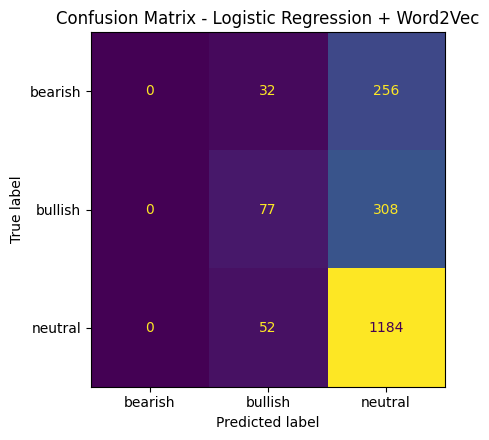

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7264

Class: bearish
  Precision: 0.5917
  Recall:    0.2964
  F1-score:  0.3949

Class: bullish
  Precision: 0.6069
  Recall:    0.4246
  F1-score:  0.4996

Class: neutral
  Precision: 0.7609
  Recall:    0.9207
  F1-score:  0.8332

Macro Avg F1-score: 0.5759

📗 VALIDATION METRICS
Accuracy: 0.7135

Class: bearish
  Precision: 0.5299
  Recall:    0.2465
  F1-score:  0.3365

Class: bullish
  Precision: 0.5742
  Recall:    0.3818
  F1-score:  0.4587

Class: neutral
  Precision: 0.7531
  Recall:    0.9256
  F1-score:  0.8305

Macro Avg F1-score: 0.5419


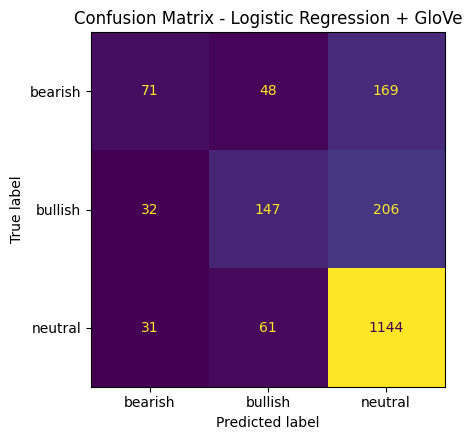

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7266

Class: bearish
  Precision: 0.5951
  Recall:    0.2955
  F1-score:  0.3949

Class: bullish
  Precision: 0.6072
  Recall:    0.4252
  F1-score:  0.5002

Class: neutral
  Precision: 0.7607
  Recall:    0.9211
  F1-score:  0.8332

Macro Avg F1-score: 0.5761

📗 VALIDATION METRICS
Accuracy: 0.7129

Class: bearish
  Precision: 0.5299
  Recall:    0.2465
  F1-score:  0.3365

Class: bullish
  Precision: 0.5720
  Recall:    0.3818
  F1-score:  0.4579

Class: neutral
  Precision: 0.7530
  Recall:    0.9248
  F1-score:  0.8301

Macro Avg F1-score: 0.5415


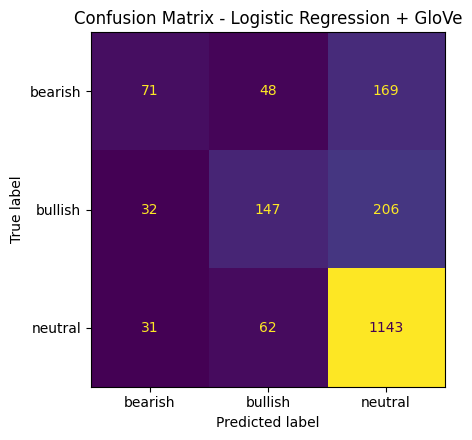

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: GloVe, Config: {'max_iter': 1000, 'solver': 'liblinear'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.7254

Class: bearish
  Precision: 0.6224
  Recall:    0.2556
  F1-score:  0.3624

Class: bullish
  Precision: 0.6073
  Recall:    0.4122
  F1-score:  0.4911

Class: neutral
  Precision: 0.7536
  Recall:    0.9326
  F1-score:  0.8336

Macro Avg F1-score: 0.5624

📗 VALIDATION METRICS
Accuracy: 0.7171

Class: bearish
  Precision: 0.5752
  Recall:    0.2257
  F1-score:  0.3242

Class: bullish
  Precision: 0.5983
  Recall:    0.3636
  F1-score:  0.4523

Class: neutral
  Precision: 0.7452
  Recall:    0.9417
  F1-score:  0.8320

Macro Avg F1-score: 0.5362


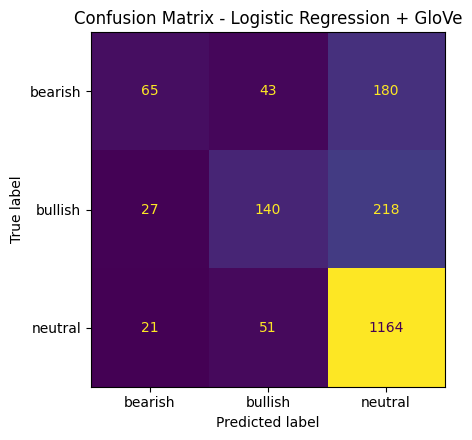

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Transformer, Config: {'max_iter': 1000, 'solver': 'lbfgs'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.8160

Class: bearish
  Precision: 0.7458
  Recall:    0.6101
  F1-score:  0.6711

Class: bullish
  Precision: 0.7589
  Recall:    0.6346
  F1-score:  0.6912

Class: neutral
  Precision: 0.8418
  Recall:    0.9205
  F1-score:  0.8794

Macro Avg F1-score: 0.7472

📗 VALIDATION METRICS
Accuracy: 0.7250

Class: bearish
  Precision: 0.5506
  Recall:    0.4722
  F1-score:  0.5084

Class: bullish
  Precision: 0.6132
  Recall:    0.4571
  F1-score:  0.5238

Class: neutral
  Precision: 0.7796
  Recall:    0.8673
  F1-score:  0.8211

Macro Avg F1-score: 0.6178


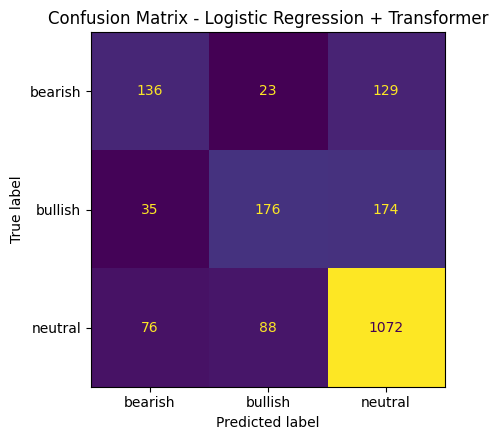

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Transformer, Config: {'max_iter': 1000, 'solver': 'saga'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.8158

Class: bearish
  Precision: 0.7473
  Recall:    0.6101
  F1-score:  0.6718

Class: bullish
  Precision: 0.7588
  Recall:    0.6339
  F1-score:  0.6908

Class: neutral
  Precision: 0.8413
  Recall:    0.9205
  F1-score:  0.8791

Macro Avg F1-score: 0.7472

📗 VALIDATION METRICS
Accuracy: 0.7234

Class: bearish
  Precision: 0.5458
  Recall:    0.4757
  F1-score:  0.5083

Class: bullish
  Precision: 0.6111
  Recall:    0.4571
  F1-score:  0.5230

Class: neutral
  Precision: 0.7796
  Recall:    0.8641
  F1-score:  0.8196

Macro Avg F1-score: 0.6170


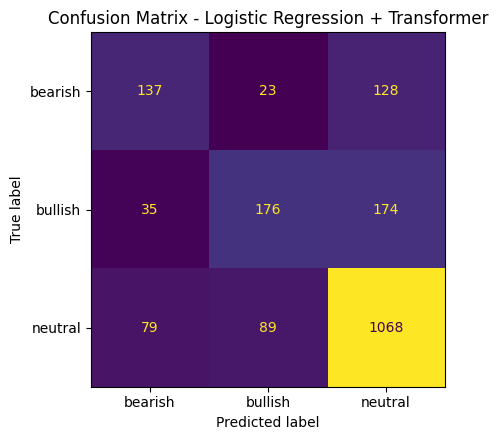

--------------------------------------------------------------------------------------

 Model: Logistic Regression, Embedding: Transformer, Config: {'max_iter': 1000, 'solver': 'liblinear'}
--------------------------------------------------------------------------------------

📘 TRAINING METRICS
Accuracy: 0.8118

Class: bearish
  Precision: 0.7559
  Recall:    0.5849
  F1-score:  0.6595

Class: bullish
  Precision: 0.7554
  Recall:    0.6144
  F1-score:  0.6777

Class: neutral
  Precision: 0.8337
  Recall:    0.9261
  F1-score:  0.8775

Macro Avg F1-score: 0.7382

📗 VALIDATION METRICS
Accuracy: 0.7344

Class: bearish
  Precision: 0.5956
  Recall:    0.4653
  F1-score:  0.5224

Class: bullish
  Precision: 0.6287
  Recall:    0.4442
  F1-score:  0.5205

Class: neutral
  Precision: 0.7769
  Recall:    0.8875
  F1-score:  0.8285

Macro Avg F1-score: 0.6238


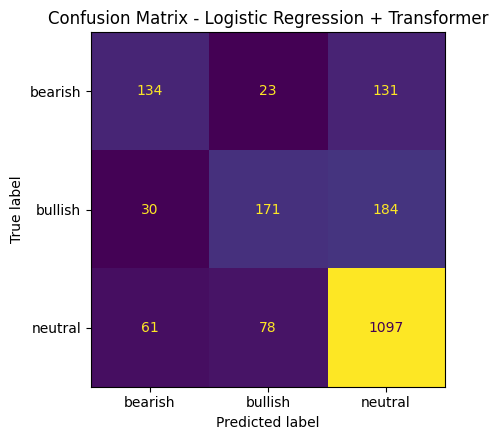

In [ ]:
results_logreg = []

for rep_name, (X_train, X_val) in feature_sets.items():
    for config in logreg_configs:
        clf = LogisticRegression(**config)
        clf.fit(X_train, y_train)
        result = evaluate_and_print(clf, X_train, y_train, X_val, y_val, "Logistic Regression", rep_name, config)
        results_logreg.append(result)

In [ ]:
# Initialize and train classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_avgembeddings_glove, y_train)

In [ ]:
y_pred_logistic = clf.predict(X_val_avgembeddings_glove)

# 9. Evaluation

## 9.1. KNN Classifier

- Evaluate KNN Classifier performance with the different feature engineering approaches.

__`Step XX`__ Evaluate KNN Classifier with BoW.

In [ ]:
accuracy = accuracy_score(y_val, y_pred_bow)

# Classification report for precision, recall, F1-score
report = classification_report(y_val, y_pred_bow, target_names=['bearish', 'bullish', 'neutral'], output_dict=True)

# Evaluation metrics
print("Accuracy: {:.4f}".format(accuracy))
print("\nClassification Report:")
for label, metrics in report.items():
    if label in ['bearish', 'bullish', 'neutral']:
        print(f"\nClass: {label}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-score:  {metrics['f1-score']:.4f}")
print(f"\nOverall Macro Avg F1-score: {report['macro avg']['f1-score']:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_bow)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bearish', 'bullish', 'neutral'])
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - KNN (Cosine Distance)")
plt.tight_layout()
plt.show()

## 9.2. Logistic Regression

In [ ]:
# Evaluate
print("\nClassification Report:")
print(classification_report(y_val, y_pred_logistic))